# Development of machine learning models to process Electronic Health Records – Explainable Models

### Imputation Notebook
Lok Hang Toby Lee (2431180L)

# Imputation

----------------------------------------------------------

In [1]:
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore')

# SET YOUR PATH FOR RESOURCES FILE HERE
resources_path = "C:/Users/USER/OneDrive/GU/Year 4/FYP/MIMIC-III-ML/data/resources"
data_path = "C:/Users/USER/OneDrive/GU/Year 4/FYP/MIMIC-III-ML/data/raw"

### Extract the variables and count the missing data

In [2]:
# Read in the data and only select the continuous variables:
config = json.load(open(resources_path + '/discretizer_config.json', 'r'))
is_categorical = config['is_categorical_channel']
categorical_var = [key for key, value in config['is_categorical_channel'].items() if value][1:]
patient_identifiers = ['icustay_id', 'subject_id', 'hadm_id', 'hours_in']
data = pd.read_csv(data_path+'/mimic_timeseries_data_not_imputed.csv')

# Filter out subjects with length of stay < 48 hours for the in-hospital mortality task:
y = pd.read_hdf(data_path+'/vitals_hourly_data_preprocessed.h5', 'Y')['los']
indices_to_remove = []
for i, row in y.iteritems():
    if row < 48:
        indices_to_remove.append(i)
        
data = data.reset_index().set_index('icustay_id').drop(indices_to_remove, axis = 0)
y = y.drop(indices_to_remove, axis = 0)

# Extract only the first 48 hours:
data = data[data['hours_in'] < 48].reset_index().set_index(['icustay_id', 'subject_id', 'hadm_id', 'hours_in']).drop('index', axis = 1)
data = data.drop('Unnamed: 0', axis = 1)


In [20]:
# Package imports
import seaborn as sns
import pandas as pd
import missingno as msno


<AxesSubplot:>

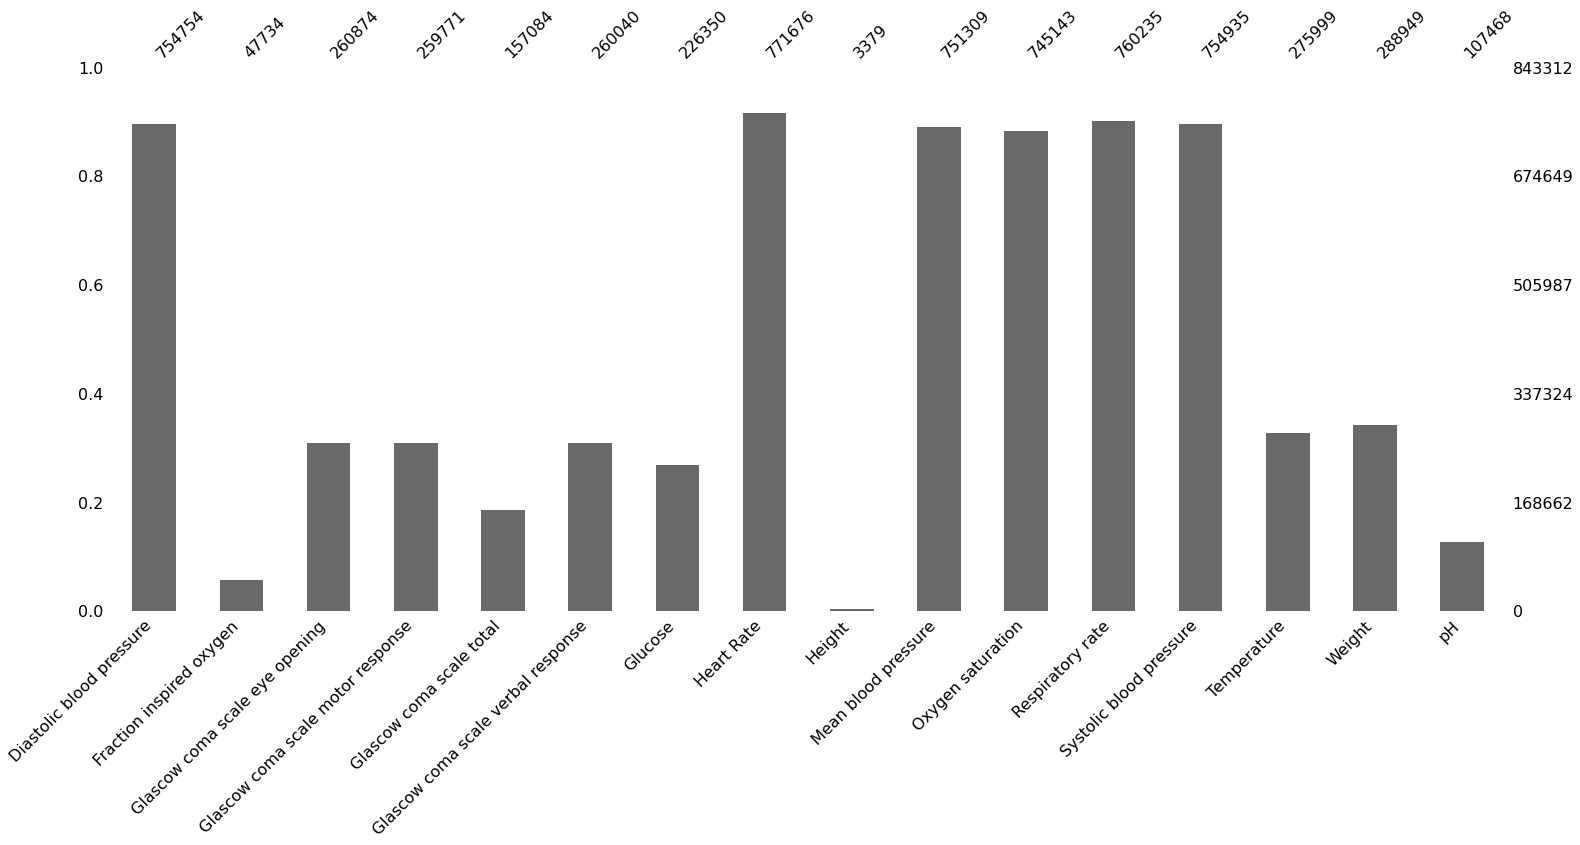

In [21]:
# Bar plot
msno.bar(data)

<AxesSubplot:>

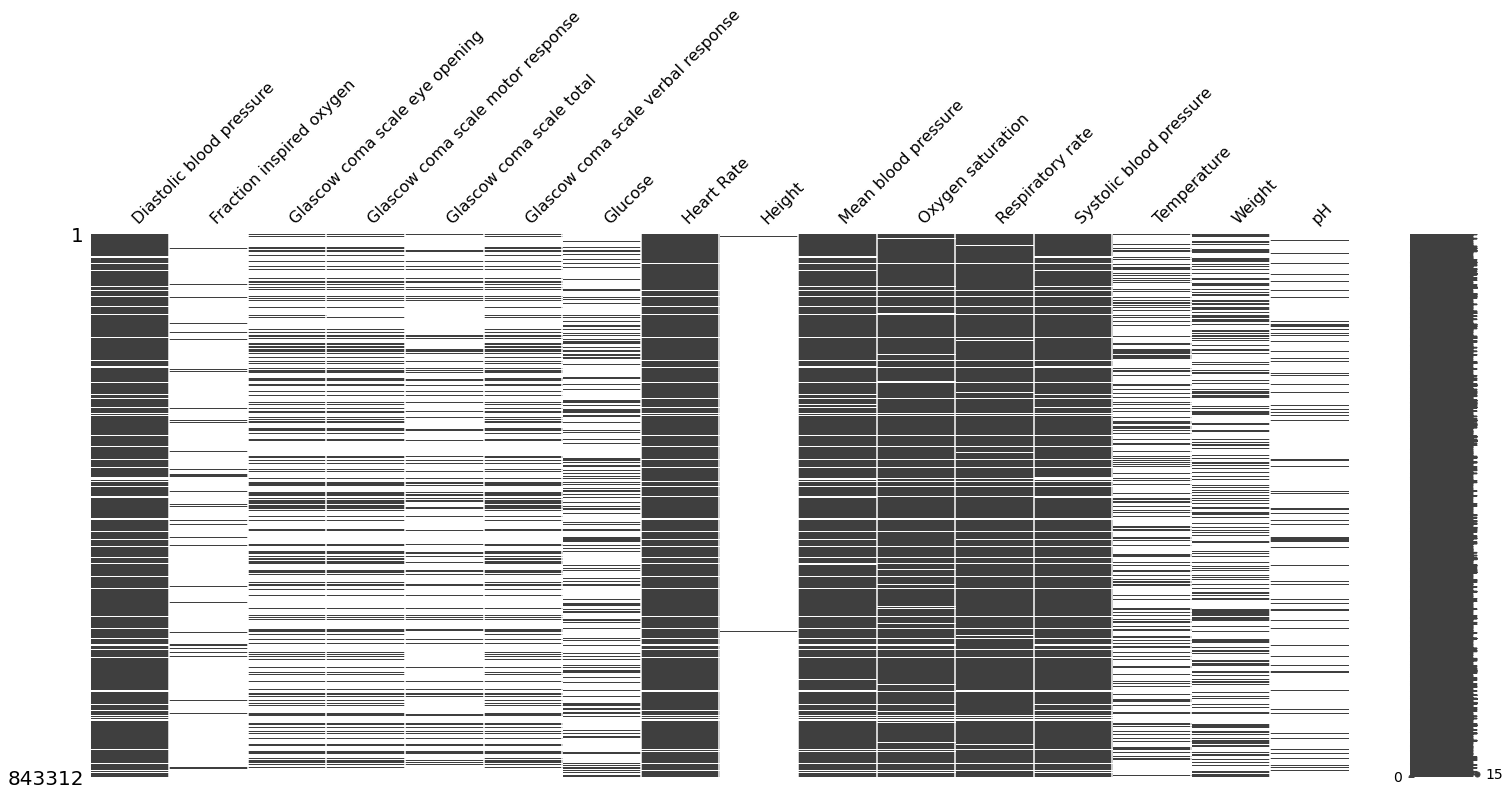

In [22]:
# Matrix plot
msno.matrix(data)

<AxesSubplot:>

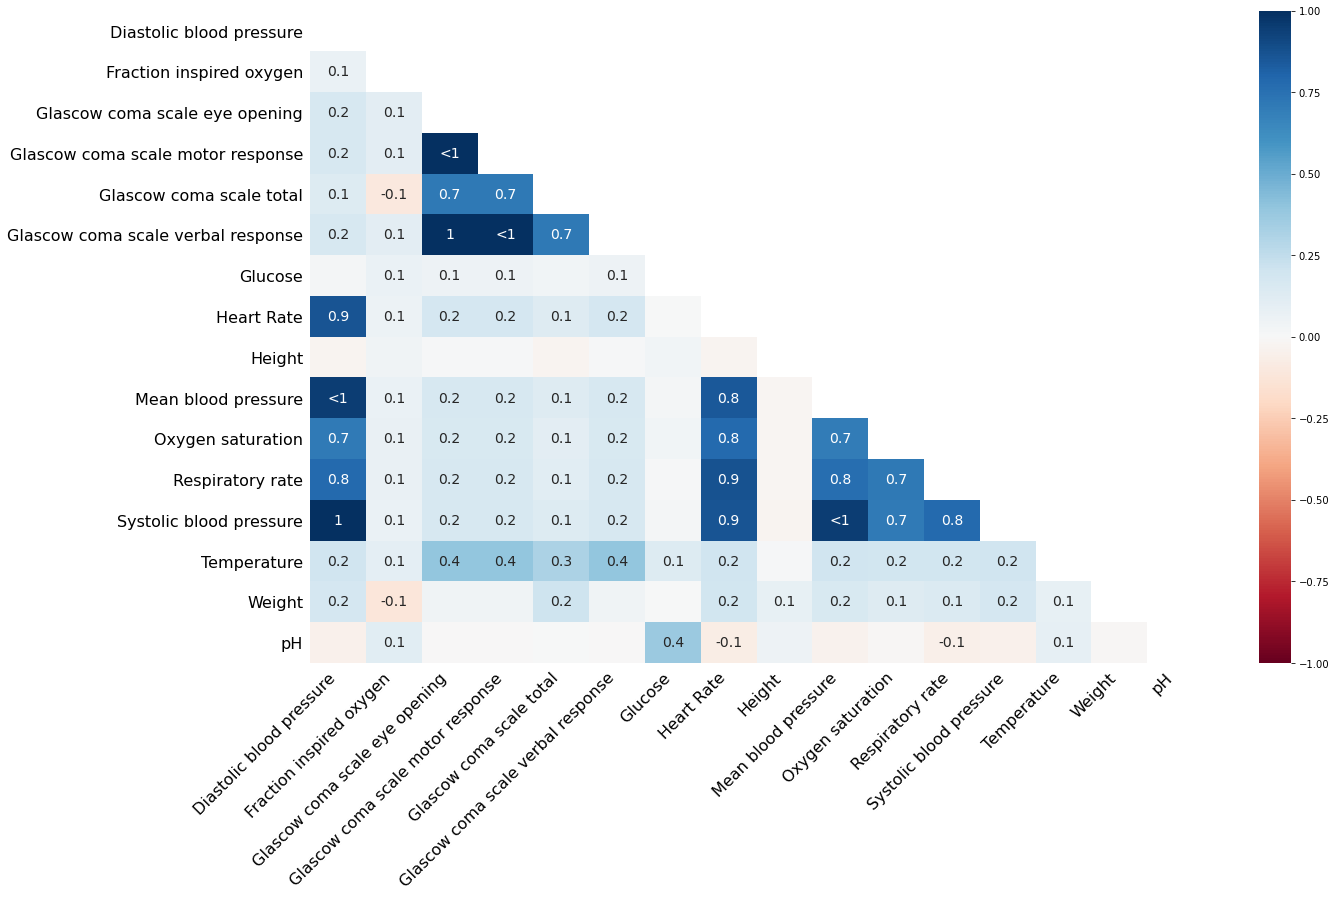

In [23]:
# Gives a heatmap of how missing values are related
msno.heatmap(data)

In [5]:
print('Number of samples: ', data.shape[0])
print('Number of ICU stays: ', len(data.groupby('icustay_id')))

non_nans_per_predictor = np.array(list(data.groupby('icustay_id').apply(lambda x: np.count_nonzero(~np.isnan(x.values[:, 4:]), 
                                                                                           axis = 0))))
total_missing_predictors = 0
for subject in non_nans_per_predictor:
    for predictor in subject:
        if predictor == 0:
            total_missing_predictors += 1
print('Total number of predictors that are missing at every hour (per subject): ', total_missing_predictors)

Number of samples:  843312
Number of ICU stays:  17569
Total number of predictors that are missing at every hour (per subject):  28794


# Mean, Most Frequent Imputation

In [18]:
from sklearn.impute import SimpleImputer
# Define the SimpleImputer instances
mean_imputer = SimpleImputer(missing_values=np.NaN, strategy='mean')
most_frequent_imputer = SimpleImputer(missing_values=np.NaN, strategy='most_frequent')

In [24]:
results_mean_imp = pd.DataFrame(index = data.index, columns = data.columns)
results_most_frequent_imp = pd.DataFrame(index = data.index, columns = data.columns)


mean_imp = mean_imputer.fit_transform(data)
results_mean_imp.loc[:,:] = mean_imp

most_frequent_imp= most_frequent_imputer.fit_transform(data)
results_most_frequent_imp.loc[:,:] = most_frequent_imp

results_mean_imp.to_csv(data_path+'/imputed_data/mean_imputed_baseline.csv')
results_most_frequent_imp.to_csv(data_path+'/imputed_data/most_frequent_imputed_baseline.csv')

In [23]:
results_mean_imp

Diastolic blood pressure  \
icustay_id subject_id hadm_id hours_in                            
200003     27513      163557  0                            49.0   
                              1                            52.0   
                              2                       52.333333   
                              3                            60.5   
                              4                            61.0   
...                                                         ...   
299995     28775      134959  43                           82.0   
                              44                      60.123802   
                              45                      60.123802   
                              46                           65.0   
                              47                      60.123802   

                                       Fraction inspired oxygen  \
icustay_id subject_id hadm_id hours_in                            
200003     27513      163557  0                        0.546117   
                              1                        0.546117   
                              2                        0.546117   
                              3                        0.546117   
                              4                        0.546117   
...                                                         ...   
299995     28775      134959  43                       0.546117   
                              44                       0.546117   
                              45                       0.546117   
                              46                       0.546117   
                              47                       0.546117   

                                       Glascow coma scale eye opening  \
icustay_id subject_id hadm_id hours_in                                  
200003     27513      163557  0                                   4.0   
                              1                              3.250058   
                              2                              3.250058   
                              3                              3.250058   
                              4                              3.250058   
...                                                               ...   
299995     28775      134959  43                             3.250058   
                              44                             3.250058   
                              45                             3.250058   
                              46                                  4.0   
                              47                             3.250058   

                                       Glascow coma scale motor response  \
icustay_id subject_id hadm_id hours_in                                     
200003     27513      163557  0                                      6.0   
                              1                                 5.366292   
                              2                                 5.366292   
                              3                                 5.366292   
                              4                                 5.366292   
...                                                                  ...   
299995     28775      134959  43                                5.366292   
                              44                                5.366292   
                              45                                5.366292   
                              46                                     6.0   
                              47                                5.366292   

                                       Glascow coma scale total  \
icustay_id subject_id hadm_id hours_in                            
200003     27513      163557  0                            15.0   
                              1                       11.964949   
                              2                       11.964949   
                     

In [1]:
results_most_frequent_imp

NameError: name 'results_most_frequent_imp' is not defined

# KNN imputation

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
#Caution! the knn imputer takes a very long time to run
results_knn_imp = pd.DataFrame(index = data.index, columns = data.columns)
scaler=StandardScaler()
scaled_data= scaler.fit_transform(data)

knn_imputer = KNNImputer(n_neighbors=5)
knn_imp = knn_imputer.fit_transform(scaled_data)

In [ ]:
knn_imp_results=scaler.inverse_transform(knn_imp)
knn_imp_data = pd.DataFrame(data=knn_imp_results, index= data.index, columns = data.columns)

knn_imp_data.to_csv(data_path+'/imputed_data/knn_imputed.csv')

In [ ]:
knn_imp_data

Diastolic blood pressure  \
icustay_id subject_id hadm_id hours_in                             
200003     27513      163557  0                        49.000000   
                              1                        52.000000   
                              2                        52.333333   
                              3                        60.500000   
                              4                        61.000000   
...                                                          ...   
299995     28775      134959  43                       82.000000   
                              44                       65.800000   
                              45                       58.600000   
                              46                       65.000000   
                              47                       60.123802   

                                        Fraction inspired oxygen  \
icustay_id subject_id hadm_id hours_in                             
200003     27513      163557  0                         0.660000   
                              1                         0.680000   
                              2                         0.590000   
                              3                         0.590000   
                              4                         0.700000   
...                                                          ...   
299995     28775      134959  43                        0.500000   
                              44                        0.600000   
                              45                        0.730000   
                              46                        0.480000   
                              47                        0.546117   

                                        Glascow coma scale eye opening  \
icustay_id subject_id hadm_id hours_in                                   
200003     27513      163557  0                               4.000000   
                              1                               4.000000   
                              2                               3.400000   
                              3                               3.400000   
                              4                               2.600000   
...                                                                ...   
299995     28775      134959  43                              3.800000   
                              44                              3.200000   
                              45                              3.600000   
                              46                              4.000000   
                              47                              3.250058   

                                        Glascow coma scale motor response  \
icustay_id subject_id hadm_id hours_in                                      
200003     27513      163557  0                                  6.000000   
                              1                                  6.000000   
                              2                                  6.000000   
                              3                                  6.000000   
                              4                                  4.800000   
...                                                                   ...   
299995     28775      134959  43                                 6.000000   
                              44                                 5.800000   
                              45                                 5.400000   
                              46                                 6.000000   
                              47                                 5.366292   

                                        Glascow coma scale total  \
icustay_id subject_id hadm_id hours_in                             
200003     27513      163557  0                        15.000000   
                              1                        13.800000   
                              2  

# Iterative Imputer

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

scaler=StandardScaler()
scaled_data= scaler.fit_transform(data)
itr_imputer = IterativeImputer(random_state=0,verbose=True)

itr_imp = itr_imputer.fit_transform(scaled_data)

[IterativeImputer] Completing matrix with shape (843312, 16)
[IterativeImputer] Change: 33.67292768428608, scaled tolerance: 0.04817750570022702 
[IterativeImputer] Change: 185.7485753713291, scaled tolerance: 0.04817750570022702 
[IterativeImputer] Change: 52.06861797349588, scaled tolerance: 0.04817750570022702 
[IterativeImputer] Change: 0.06134734012373455, scaled tolerance: 0.04817750570022702 
[IterativeImputer] Change: 5.1458663753556344e-05, scaled tolerance: 0.04817750570022702 
[IterativeImputer] Early stopping criterion reached.


In [5]:
itr_results=scaler.inverse_transform(itr_imp)
itr_imp_data = pd.DataFrame(data=itr_results, index= data.index, columns = data.columns)
itr_imp_data.to_csv(data_path+'/imputed_data/itr_imputed.csv')

In [6]:
itr_imp_data

Diastolic blood pressure  \
icustay_id subject_id hadm_id hours_in                             
200003     27513      163557  0                        49.000000   
                              1                        52.000000   
                              2                        52.333333   
                              3                        60.500000   
                              4                        61.000000   
...                                                          ...   
299995     28775      134959  43                       82.000000   
                              44                       58.799468   
                              45                       59.755970   
                              46                       65.000000   
                              47                       60.143834   

                                        Fraction inspired oxygen  \
icustay_id subject_id hadm_id hours_in                             
200003     27513      163557  0                         0.631080   
                              1                         0.534917   
                              2                         0.578130   
                              3                         0.618695   
                              4                         0.687274   
...                                                          ...   
299995     28775      134959  43                        0.562245   
                              44                        0.557427   
                              45                        0.563740   
                              46                        0.617083   
                              47                        0.564790   

                                        Glascow coma scale eye opening  \
icustay_id subject_id hadm_id hours_in                                   
200003     27513      163557  0                               4.000000   
                              1                               3.273093   
                              2                               3.314933   
                              3                               3.358844   
                              4                               3.433102   
...                                                                ...   
299995     28775      134959  43                              3.234122   
                              44                              3.239895   
                              45                              3.251773   
                              46                              4.000000   
                              47                              3.253275   

                                        Glascow coma scale motor response  \
icustay_id subject_id hadm_id hours_in                                      
200003     27513      163557  0                                  6.000000   
                              1                                  5.692473   
                              2                                  5.558320   
                              3                                  5.496426   
                              4                                  5.356906   
...                                                                   ...   
299995     28775      134959  43                                 5.409954   
                              44                                 5.370495   
                              45                                 5.369566   
                              46                                 6.000000   
                              47                                 5.363548   

                                        Glascow coma scale total  \
icustay_id subject_id hadm_id hours_in                             
200003     27513      163557  0                        15.000000   
                              1                        11.992725   
                              2  

# MICE

In [5]:
import miceforest as mf

mf.ampute_data(data,perc=0.25)

# Create kernels. 
kernel = mf.ImputationKernel(
  data=data,
  datasets=4,
  save_all_iterations=True,
  random_state=1991
)

In [ ]:
# Run the MICE algorithm for 3 iterations on each of the datasets
kernel.mice(3,verbose=True)

In [82]:
optimal_parameters, losses = kernel.tune_parameters(
  dataset=0,
  optimization_steps=5
)

# Run mice with our newly tuned parameters.
kernel.mice(1, variable_parameters=optimal_parameters)
7
# The optimal parameters are kept in ImputationKernel.optimal_parameters:
print(optimal_parameters)



{7: {'boosting': 'gbdt', 'num_iterations': 5000, 'max_depth': 8, 'num_leaves': 14, 'min_data_in_leaf': 29025, 'min_sum_hessian_in_leaf': 0.1, 'min_gain_to_split': 0.0, 'bagging_fraction': 0.6116460024199847, 'feature_fraction': 1.0, 'feature_fraction_bynode': 0.4853652724039139, 'bagging_freq': 1, 'verbosity': -1, 'objective': 'regression', 'seed': 635355, 'learning_rate': 0.05, 'cat_smooth': 23.629257396732374}, 11: {'boosting': 'gbdt', 'num_iterations': 5000, 'max_depth': 8, 'num_leaves': 18, 'min_data_in_leaf': 46539, 'min_sum_hessian_in_leaf': 0.1, 'min_gain_to_split': 0.0, 'bagging_fraction': 0.7406864914680863, 'feature_fraction': 1.0, 'feature_fraction_bynode': 0.6938637860511762, 'bagging_freq': 1, 'verbosity': -1, 'objective': 'regression', 'seed': 963763, 'learning_rate': 0.05, 'cat_smooth': 20.277040417276172}, 12: {'boosting': 'gbdt', 'num_iterations': 5000, 'max_depth': 8, 'num_leaves': 13, 'min_data_in_leaf': 28478, 'min_sum_hessian_in_leaf': 0.1, 'min_gain_to_split': 0.0

In [6]:
optimal_parameters={7: {'boosting': 'gbdt', 'num_iterations': 5000, 'max_depth': 8, 'num_leaves': 14, 'min_data_in_leaf': 29025, 'min_sum_hessian_in_leaf': 0.1, 'min_gain_to_split': 0.0, 'bagging_fraction': 0.6116460024199847, 'feature_fraction': 1.0, 'feature_fraction_bynode': 0.4853652724039139, 'bagging_freq': 1, 'verbosity': -1, 'objective': 'regression', 'seed': 635355, 'learning_rate': 0.05, 'cat_smooth': 23.629257396732374}, 11: {'boosting': 'gbdt', 'num_iterations': 5000, 'max_depth': 8, 'num_leaves': 18, 'min_data_in_leaf': 46539, 'min_sum_hessian_in_leaf': 0.1, 'min_gain_to_split': 0.0, 'bagging_fraction': 0.7406864914680863, 'feature_fraction': 1.0, 'feature_fraction_bynode': 0.6938637860511762, 'bagging_freq': 1, 'verbosity': -1, 'objective': 'regression', 'seed': 963763, 'learning_rate': 0.05, 'cat_smooth': 20.277040417276172}, 12: {'boosting': 'gbdt', 'num_iterations': 5000, 'max_depth': 8, 'num_leaves': 13, 'min_data_in_leaf': 28478, 'min_sum_hessian_in_leaf': 0.1, 'min_gain_to_split': 0.0, 'bagging_fraction': 0.7224280952458146, 'feature_fraction': 1.0, 'feature_fraction_bynode': 0.549284787782835, 'bagging_freq': 1, 'verbosity': -1, 'objective': 'regression', 'seed': 216295, 'learning_rate': 0.05, 'cat_smooth': 20.845191150511962}, 0: {'boosting': 'gbdt', 'num_iterations': 5000, 'max_depth': 8, 'num_leaves': 16, 'min_data_in_leaf': 53130, 'min_sum_hessian_in_leaf': 0.1, 'min_gain_to_split': 0.0, 'bagging_fraction': 0.9771906149487628, 'feature_fraction': 1.0, 'feature_fraction_bynode': 0.9208567620588631, 'bagging_freq': 1, 'verbosity': -1, 'objective': 'regression', 'seed': 592335, 'learning_rate': 0.05, 'cat_smooth': 2.9558111585524545}, 9: {'boosting': 'gbdt', 'num_iterations': 2407, 'max_depth': 8, 'num_leaves': 12, 'min_data_in_leaf': 4186, 'min_sum_hessian_in_leaf': 0.1, 'min_gain_to_split': 0.0, 'bagging_fraction': 0.3185085699966633, 'feature_fraction': 1.0, 'feature_fraction_bynode': 0.8664728224215659, 'bagging_freq': 1, 'verbosity': -1, 'objective': 'regression', 'seed': 347490, 'learning_rate': 0.05, 'cat_smooth': 9.160646730591216}, 10: {'boosting': 'gbdt', 'num_iterations': 1771, 'max_depth': 8, 'num_leaves': 23, 'min_data_in_leaf': 3095, 'min_sum_hessian_in_leaf': 0.1, 'min_gain_to_split': 0.0, 'bagging_fraction': 0.35404184173949216, 'feature_fraction': 1.0, 'feature_fraction_bynode': 0.26378529369316644, 'bagging_freq': 1, 'verbosity': -1, 'objective': 'regression', 'seed': 549843, 'learning_rate': 0.05, 'cat_smooth': 12.109747961091713}, 14: {'boosting': 'gbdt', 'num_iterations': 1366, 'max_depth': 8, 'num_leaves': 17, 'min_data_in_leaf': 648, 'min_sum_hessian_in_leaf': 0.1, 'min_gain_to_split': 0.0, 'bagging_fraction': 0.5240446778187317, 'feature_fraction': 1.0, 'feature_fraction_bynode': 0.6898016586044188, 'bagging_freq': 1, 'verbosity': -1, 'objective': 'regression', 'seed': 695751, 'learning_rate': 0.05, 'cat_smooth': 9.359330730126967}, 13: {'boosting': 'gbdt', 'num_iterations': 4306, 'max_depth': 8, 'num_leaves': 24, 'min_data_in_leaf': 9906, 'min_sum_hessian_in_leaf': 0.1, 'min_gain_to_split': 0.0, 'bagging_fraction': 0.8139546334618256, 'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7501835065984781, 'bagging_freq': 1, 'verbosity': -1, 'objective': 'regression', 'seed': 477155, 'learning_rate': 0.05, 'cat_smooth': 9.664000784964383}, 2: {'boosting': 'gbdt', 'num_iterations': 4927, 'max_depth': 8, 'num_leaves': 8, 'min_data_in_leaf': 5976, 'min_sum_hessian_in_leaf': 0.1, 'min_gain_to_split': 0.0, 'bagging_fraction': 0.6467662968495774, 'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7881371834576874, 'bagging_freq': 1, 'verbosity': -1, 'objective': 'regression', 'seed': 599809, 'learning_rate': 0.05, 'cat_smooth': 14.064176006097743}, 5: {'boosting': 'gbdt', 'num_iterations': 4999, 'max_depth': 8, 'num_leaves': 14, 'min_data_in_leaf': 8341, 'min_sum_hessian_in_leaf': 0.1, 'min_gain_to_split': 0.0, 'bagging_fraction': 0.8113716443633006, 'feature_fraction': 1.0, 'feature_fraction_bynode': 0.6271055492984837, 'bagging_freq': 1, 'verbosity': -1, 'objective': 'regression', 'seed': 460998, 'learning_rate': 0.05, 'cat_smooth': 14.388532491341138}, 3: {'boosting': 'gbdt', 'num_iterations': 1820, 'max_depth': 8, 'num_leaves': 24, 'min_data_in_leaf': 1226, 'min_sum_hessian_in_leaf': 0.1, 'min_gain_to_split': 0.0, 'bagging_fraction': 0.7307860355171651, 'feature_fraction': 1.0, 'feature_fraction_bynode': 0.4027123149811854, 'bagging_freq': 1, 'verbosity': -1, 'objective': 'regression', 'seed': 476956, 'learning_rate': 0.05, 'cat_smooth': 1.0531589531064978}, 6: {'boosting': 'gbdt', 'num_iterations': 2378, 'max_depth': 8, 'num_leaves': 9, 'min_data_in_leaf': 7576, 'min_sum_hessian_in_leaf': 0.1, 'min_gain_to_split': 0.0, 'bagging_fraction': 0.8781416185329748, 'feature_fraction': 1.0, 'feature_fraction_bynode': 0.7074383770513859, 'bagging_freq': 1, 'verbosity': -1, 'objective': 'regression', 'seed': 359880, 'learning_rate': 0.05, 'cat_smooth': 0.009484523593586425}, 4: {'boosting': 'gbdt', 'num_iterations': 5000, 'max_depth': 8, 'num_leaves': 13, 'min_data_in_leaf': 212, 'min_sum_hessian_in_leaf': 0.1, 'min_gain_to_split': 0.0, 'bagging_fraction': 0.7782329350790853, 'feature_fraction': 1.0, 'feature_fraction_bynode': 0.4326679622458992, 'bagging_freq': 1, 'verbosity': -1, 'objective': 'regression', 'seed': 51950, 'learning_rate': 0.05, 'cat_smooth': 24.501566520213196}, 15: {'boosting': 'gbdt', 'num_iterations': 1756, 'max_depth': 8, 'num_leaves': 22, 'min_data_in_leaf': 2499, 'min_sum_hessian_in_leaf': 0.1, 'min_gain_to_split': 0.0, 'bagging_fraction': 0.9940340854543842, 'feature_fraction': 1.0, 'feature_fraction_bynode': 0.3717374193526257, 'bagging_freq': 1, 'verbosity': -1, 'objective': 'regression', 'seed': 537943, 'learning_rate': 0.05, 'cat_smooth': 14.890905942285512}, 1: {'boosting': 'gbdt', 'num_iterations': 786, 'max_depth': 8, 'num_leaves': 8, 'min_data_in_leaf': 1328, 'min_sum_hessian_in_leaf': 0.1, 'min_gain_to_split': 0.0, 'bagging_fraction': 0.9464946314857885, 'feature_fraction': 1.0, 'feature_fraction_bynode': 0.9161614326713303, 'bagging_freq': 1, 'verbosity': -1, 'objective': 'regression', 'seed': 522585, 'learning_rate': 0.05, 'cat_smooth': 4.6286175450106635}, 8: {'boosting': 'gbdt', 'num_iterations': 109, 'max_depth': 8, 'num_leaves': 12, 'min_data_in_leaf': 324, 'min_sum_hessian_in_leaf': 0.1, 'min_gain_to_split': 0.0, 'bagging_fraction': 0.5733322046975943, 'feature_fraction': 1.0, 'feature_fraction_bynode': 0.36988828476178337, 'bagging_freq': 1, 'verbosity': -1, 'objective': 'regression', 'seed': 107227, 'learning_rate': 0.05, 'cat_smooth': 7.310993877763838}}

In [7]:
kernel.mice(3, verbose=True, variable_parameters=optimal_parameters)

Dataset 0
1  | Heart Rate | Respiratory rate | Systolic blood pressure | Diastolic blood pressure | Mean blood pressure | Oxygen saturation | Weight | Temperature | Glascow coma scale eye opening | Glascow coma scale verbal response | Glascow coma scale motor response | Glucose | Glascow coma scale total | pH | Fraction inspired oxygen | Height
2  | Heart Rate | Respiratory rate | Systolic blood pressure | Diastolic blood pressure | Mean blood pressure | Oxygen saturation | Weight | Temperature | Glascow coma scale eye opening | Glascow coma scale verbal response | Glascow coma scale motor response | Glucose | Glascow coma scale total | pH | Fraction inspired oxygen | Height
3  | Heart Rate | Respiratory rate | Systolic blood pressure | Diastolic blood pressure | Mean blood pressure | Oxygen saturation | Weight | Temperature | Glascow coma scale eye opening | Glascow coma scale verbal response | Glascow coma scale motor response | Glucose | Glascow coma scale total | pH | Fraction insp

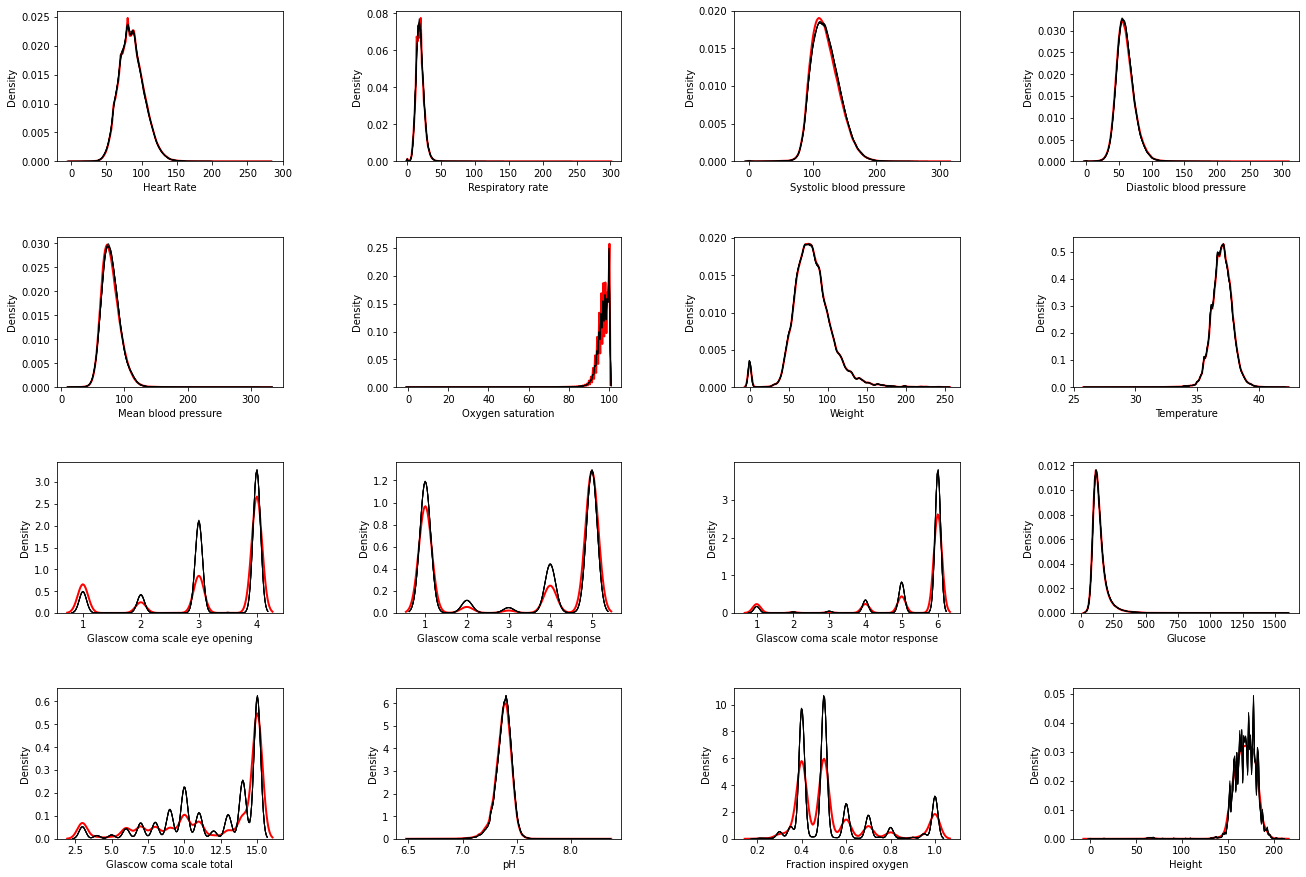

In [8]:
fig = kernel.plot_imputed_distributions(right=3,top=3,wspace=0.5,hspace=0.5)

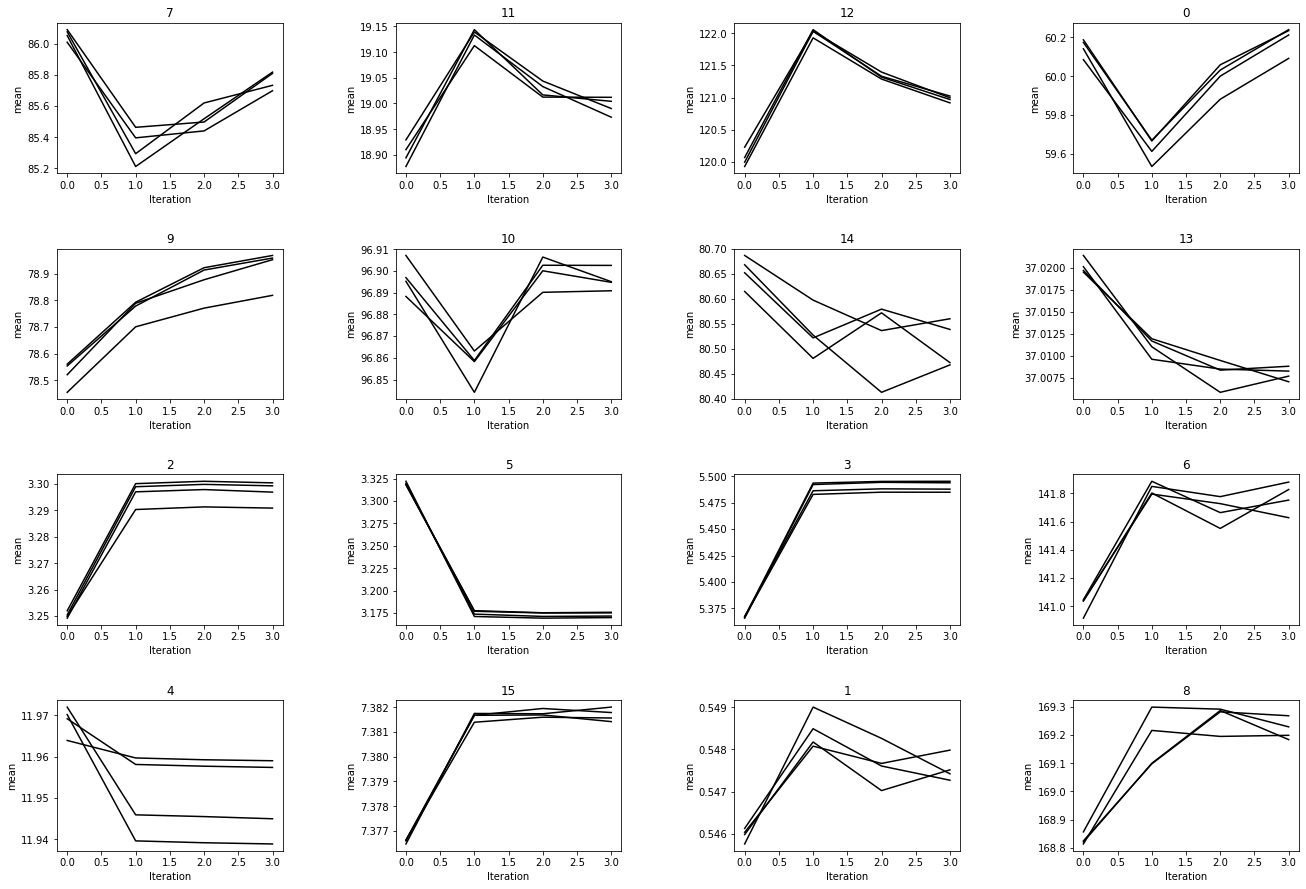

In [9]:
kernel.plot_mean_convergence(right=3,top=3,wspace=0.5,hspace=0.5)


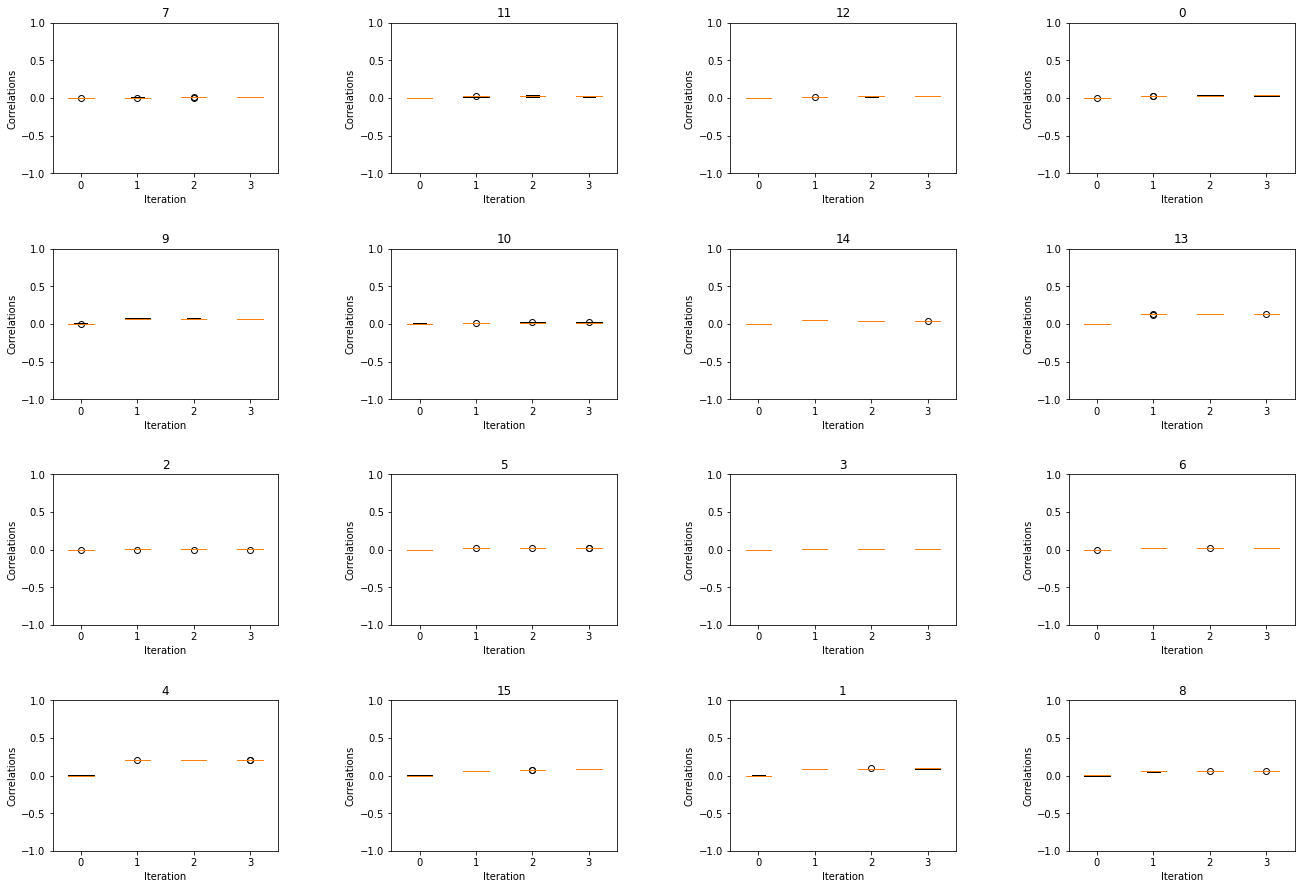

In [10]:
fig = kernel.plot_correlations(right=3,top=3,wspace=0.5,hspace=0.5)

AxesSubplot(0.125,0.125;0.62x0.755)


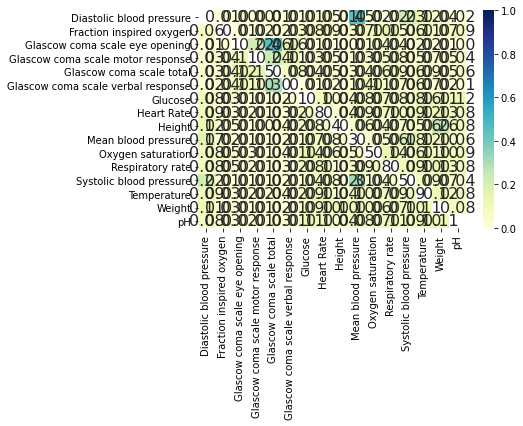

In [11]:
import matplotlib as plt
fig= kernel.plot_feature_importance(dataset=0, annot=True,cmap="YlGnBu",vmin=0, vmax=1)


In [14]:
mice_imputed_data = kernel.complete_data(2)

In [15]:
mice_imputed_data

Diastolic blood pressure  \
icustay_id subject_id hadm_id hours_in                             
200003     27513      163557  0                        49.000000   
                              1                        52.000000   
                              2                        52.333333   
                              3                        60.500000   
                              4                        61.000000   
...                                                          ...   
299995     28775      134959  43                       82.000000   
                              44                       72.000000   
                              45                       40.000000   
                              46                       65.000000   
                              47                       60.000000   

                                        Fraction inspired oxygen  \
icustay_id subject_id hadm_id hours_in                             
200003     27513      163557  0                             1.00   
                              1                             0.40   
                              2                             0.40   
                              3                             0.60   
                              4                             1.00   
...                                                          ...   
299995     28775      134959  43                            0.40   
                              44                            0.60   
                              45                            0.50   
                              46                            0.35   
                              47                            0.50   

                                        Glascow coma scale eye opening  \
icustay_id subject_id hadm_id hours_in                                   
200003     27513      163557  0                                    4.0   
                              1                                    4.0   
                              2                                    2.0   
                              3                                    4.0   
                              4                                    4.0   
...                                                                ...   
299995     28775      134959  43                                   3.0   
                              44                                   2.0   
                              45                                   3.0   
                              46                                   4.0   
                              47                                   4.0   

                                        Glascow coma scale motor response  \
icustay_id subject_id hadm_id hours_in                                      
200003     27513      163557  0                                       6.0   
                              1                                       6.0   
                              2                                       5.0   
                              3                                       6.0   
                              4                                       6.0   
...                                                                   ...   
299995     28775      134959  43                                      6.0   
                              44                                      4.0   
                              45                                      6.0   
                              46                                      6.0   
                              47                                      6.0   

                                        Glascow coma scale total  \
icustay_id subject_id hadm_id hours_in                             
200003     27513      163557  0                             15.0   
                              1                             15.0   
                              2  

### Take mean of dataset and round catagorial variables

In [16]:
completed_dataset1 = kernel.complete_data(dataset=0, inplace=False)
completed_dataset2 = kernel.complete_data(dataset=1, inplace=False)
completed_dataset3 = kernel.complete_data(dataset=2, inplace=False)
completed_dataset4 = kernel.complete_data(dataset=3, inplace=False)

mice_imputed_results= (completed_dataset1 + completed_dataset2 + completed_dataset3+ completed_dataset4)/4
# for i in range(len(mice_imputed_results.columns)): # round categorical to closest category
#     if mice_imputed_results.columns[i] in categorical_var:
#         mice_imputed_results[mice_imputed_results.columns[i]] = np.round(mice_imputed_results[mice_imputed_results.columns[i]])  

In [17]:
mice_imputed_results

Diastolic blood pressure  \
icustay_id subject_id hadm_id hours_in                             
200003     27513      163557  0                        49.000000   
                              1                        52.000000   
                              2                        52.333333   
                              3                        60.500000   
                              4                        61.000000   
...                                                          ...   
299995     28775      134959  43                       82.000000   
                              44                       51.375000   
                              45                       54.375000   
                              46                       65.000000   
                              47                       65.000000   

                                        Fraction inspired oxygen  \
icustay_id subject_id hadm_id hours_in                             
200003     27513      163557  0                           0.7750   
                              1                           0.7500   
                              2                           0.6500   
                              3                           0.6625   
                              4                           0.9000   
...                                                          ...   
299995     28775      134959  43                          0.6250   
                              44                          0.7000   
                              45                          0.4500   
                              46                          0.4375   
                              47                          0.4875   

                                        Glascow coma scale eye opening  \
icustay_id subject_id hadm_id hours_in                                   
200003     27513      163557  0                                   4.00   
                              1                                   3.00   
                              2                                   2.75   
                              3                                   3.75   
                              4                                   4.00   
...                                                                ...   
299995     28775      134959  43                                  3.50   
                              44                                  3.50   
                              45                                  3.50   
                              46                                  4.00   
                              47                                  3.25   

                                        Glascow coma scale motor response  \
icustay_id subject_id hadm_id hours_in                                      
200003     27513      163557  0                                      6.00   
                              1                                      4.75   
                              2                                      5.75   
                              3                                      6.00   
                              4                                      6.00   
...                                                                   ...   
299995     28775      134959  43                                     6.00   
                              44                                     5.50   
                              45                                     5.50   
                              46                                     6.00   
                              47                                     6.00   

                                        Glascow coma scale total  \
icustay_id subject_id hadm_id hours_in                             
200003     27513      163557  0                            15.00   
                              1                            10.75   
                              2  

In [18]:
mice_imputed_results.to_csv(data_path+'/imputed_data/mice_imputed_final.csv')

In [65]:
mice_imputed_results

Diastolic blood pressure  \
icustay_id subject_id hadm_id hours_in                             
200003     27513      163557  0                        49.000000   
                              1                        52.000000   
                              2                        52.333333   
                              3                        60.500000   
                              4                        61.000000   
...                                                          ...   
299995     28775      134959  43                       82.000000   
                              44                       50.500000   
                              45                       57.125000   
                              46                       65.000000   
                              47                       59.000000   

                                        Fraction inspired oxygen  \
icustay_id subject_id hadm_id hours_in                             
200003     27513      163557  0                           0.8125   
                              1                           0.6250   
                              2                           0.7250   
                              3                           0.8000   
                              4                           0.8625   
...                                                          ...   
299995     28775      134959  43                          0.6500   
                              44                          0.5000   
                              45                          0.4125   
                              46                          0.6750   
                              47                          0.5000   

                                        Glascow coma scale eye opening  \
icustay_id subject_id hadm_id hours_in                                   
200003     27513      163557  0                                   4.00   
                              1                                   3.25   
                              2                                   3.25   
                              3                                   4.00   
                              4                                   4.00   
...                                                                ...   
299995     28775      134959  43                                  3.75   
                              44                                  2.75   
                              45                                  3.75   
                              46                                  4.00   
                              47                                  4.00   

                                        Glascow coma scale motor response  \
icustay_id subject_id hadm_id hours_in                                      
200003     27513      163557  0                                      6.00   
                              1                                      5.50   
                              2                                      5.25   
                              3                                      6.00   
                              4                                      5.00   
...                                                                   ...   
299995     28775      134959  43                                     5.75   
                              44                                     5.00   
                              45                                     5.75   
                              46                                     6.00   
                              47                                     5.75   

                                        Glascow coma scale total  \
icustay_id subject_id hadm_id hours_in                             
200003     27513      163557  0                            15.00   
                              1                            12.00   
                              2  

# Multiple Imputation using Denoising Autoencoders (MIDAs)

In [40]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import tensorflow as tf
import MIDASpy as md

In [42]:
data_0=data.reset_index()
categorical  = categorical_var
data_cat, cat_cols_list = md.cat_conv(data_0[categorical])

data_0.drop(categorical, axis = 1, inplace = True)
constructor_list = [data_0]
constructor_list.append(data_cat)
data_in = pd.concat(constructor_list, axis=1)

na_loc = data_in.isnull()
data_in[na_loc] = np.nan



In [43]:
data_in 

,icustay_id,subject_id,hadm_id,hours_in,Diastolic blood pressure,Fraction inspired oxygen,Glucose,Heart Rate,Height,Mean blood pressure,...,Glascow coma scale verbal response_3.111111111111111,Glascow coma scale verbal response_3.5,Glascow coma scale verbal response_3.6666666666666665,Glascow coma scale verbal response_3.75,Glascow coma scale verbal response_4.0,Glascow coma scale verbal response_4.25,Glascow coma scale verbal response_4.333333333333333,Glascow coma scale verbal response_4.5,Glascow coma scale verbal response_4.666666666666667,Glascow coma scale verbal response_5.0
0,200003,27513,163557,0,49.000000,NaN,110.0,119.0,NaN,58.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,200003,27513,163557,1,52.000000,NaN,NaN,118.0,NaN,59.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,200003,27513,163557,2,52.333333,NaN,NaN,116.0,NaN,59.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,200003,27513,163557,3,60.500000,NaN,NaN,112.0,NaN,65.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,200003,27513,163557,4,61.000000,NaN,NaN,108.0,NaN,67.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
843307,299995,28775,134959,43,82.000000,NaN,NaN,74.0,NaN,93.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
843308,299995,28775,134959,44,NaN,NaN,NaN,72.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
843309,299995,28775,134959,45,NaN,NaN,NaN,82.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
843310,299995,28775,134959,46,65.000000,NaN,NaN,73.0,NaN,81.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [44]:
imputer = md.Midas(layer_structure = [256,256], vae_layer = False, seed = 2000, input_drop = 0.85)
imputer.build_model(data_in)
imputer.train_model(training_epochs = 10)

Size index: [110]

Computation graph constructed

Model initialised

Epoch: 0 , loss: 120780.05929685573
Epoch: 1 , loss: 105191.54842032072
Epoch: 2 , loss: 103557.5764078864
Epoch: 3 , loss: 102729.36170598782
Epoch: 4 , loss: 102064.11723804475
Epoch: 5 , loss: 101605.80584743546
Epoch: 6 , loss: 101287.71380150526
Epoch: 7 , loss: 100896.73318023163
Epoch: 8 , loss: 100637.5752979769
Epoch: 9 , loss: 100494.56939194805
Training complete. Saving file...
Model saved in file: tmp/MIDAS


In [45]:
imputations = imputer.generate_samples(m=10).output_list 
imputations=[imputations]

results=imputations

INFO:tensorflow:Restoring parameters from tmp/MIDAS
Model restored.


In [46]:
imputations=imputations[0]

In [48]:
flat_cats = [cat for variable in cat_cols_list for cat in variable]

for i in range(len(imputations)):
    tmp_cat = [imputations[i][x].idxmax(axis=1) for x in cat_cols_list]
    cat_df = pd.DataFrame({categorical[i]:tmp_cat[i] for i in range(len(categorical))})
    imputations[i] = pd.concat([imputations[i], cat_df], axis = 1).drop(flat_cats, axis = 1)

imputations=imputations[0]

In [50]:
def removeText(value):
    if "Glascow coma scale eye opening_" in value:
        value=value.replace("Glascow coma scale eye opening_", "")
        value=float(value)
    elif "Glascow coma scale motor response_" in value:
        value=value.replace("Glascow coma scale motor response_", "")
        value=float(value)
    elif "Glascow coma scale total_" in value:
        value=value.replace("Glascow coma scale total_", "")
        value=float(value)
    elif "Glascow coma scale verbal response_" in value:
        value=value.replace("Glascow coma scale verbal response_", "")
        value=float(value)
    
    return value

In [53]:
imputations['Glascow coma scale eye opening']=imputations['Glascow coma scale eye opening'].apply(removeText)
imputations['Glascow coma scale motor response']=imputations['Glascow coma scale motor response'].apply(removeText)
imputations['Glascow coma scale total']=imputations['Glascow coma scale total'].apply(removeText)
imputations['Glascow coma scale verbal response']=imputations['Glascow coma scale verbal response'].apply(removeText)

In [55]:
imputations=imputations[['icustay_id', 'subject_id', 'hadm_id', 'hours_in',
       'Diastolic blood pressure', 'Fraction inspired oxygen',
       'Glascow coma scale eye opening', 'Glascow coma scale motor response',
       'Glascow coma scale total', 'Glascow coma scale verbal response',
       'Glucose', 'Heart Rate', 'Height', 'Mean blood pressure',
       'Oxygen saturation', 'Respiratory rate', 'Systolic blood pressure',
       'Temperature', 'Weight', 'pH']]

In [56]:
midas_imputed = imputations.reset_index().set_index(['icustay_id', 'subject_id', 'hadm_id', 'hours_in']).drop('index', axis = 1)
midas_imputed.to_csv(data_path+'/imputed_data/midas_imputed.csv')

In [57]:
midas_imputed

Diastolic blood pressure  \
icustay_id subject_id hadm_id hours_in                             
200003     27513      163557  0                        49.000000   
                              1                        52.000000   
                              2                        52.333333   
                              3                        60.500000   
                              4                        61.000000   
...                                                          ...   
299995     28775      134959  43                       82.000000   
                              44                       89.523979   
                              45                       76.478981   
                              46                       65.000000   
                              47                       66.503204   

                                        Fraction inspired oxygen  \
icustay_id subject_id hadm_id hours_in                             
200003     27513      163557  0                         9.808411   
                              1                        38.538990   
                              2                       -59.124378   
                              3                        71.913162   
                              4                       -28.294315   
...                                                          ...   
299995     28775      134959  43                     -129.242371   
                              44                       40.845825   
                              45                      100.919701   
                              46                      -69.222435   
                              47                       30.210646   

                                        Glascow coma scale eye opening  \
icustay_id subject_id hadm_id hours_in                                   
200003     27513      163557  0                               4.000000   
                              1                               3.500000   
                              2                               2.750000   
                              3                               1.500000   
                              4                               2.750000   
...                                                                ...   
299995     28775      134959  43                              1.500000   
                              44                              1.333333   
                              45                              3.000000   
                              46                              4.000000   
                              47                              1.666667   

                                        Glascow coma scale motor response  \
icustay_id subject_id hadm_id hours_in                                      
200003     27513      163557  0                                  6.000000   
                              1                                  2.333333   
                              2                                  5.000000   
                              3                                  5.333333   
                              4                                  2.666667   
...                                                                   ...   
299995     28775      134959  43                                 5.500000   
                              44                                 3.000000   
                              45                                 3.000000   
                              46                                 6.000000   
                              47                                 4.500000   

                                        Glascow coma scale total  \
icustay_id subject_id hadm_id hours_in                             
200003     27513      163557  0                        15.000000   
                              1                        13.000000   
                              2  